In [1]:
import cv2
import time
import numpy as np
import argparse
import matplotlib.pyplot as plt
import csv
import itertools
import pandas as pd
import os
import sys
import tempfile
import tqdm
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from enum import Enum
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
%matplotlib inline

In [2]:
class BodyPart(Enum):
  r_ankle = 0
  r_knee = 1
  r_hip = 2
  l_hip = 3
  l_knee = 4
  l_ankle = 5
  pelvis = 6
  thorax = 7
  upper_neck = 8
  head_top = 9
  r_wist = 10
  r_shoulder = 12
  l_shoulder = 13
  l_elbow = 14
  l_wrist = 15

In [3]:
# Prepare Network and Model Weights
protoFile = "/content/drive/MyDrive/mpi/pose_deploy_linevec_faster_4_stages.prototxt" # Network
weightsFile = "/content/drive/MyDrive/mpi/pose_iter_160000.caffemodel" # Model Weights
nPoints = 15
POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]

In [4]:
# image = cv2.imread('/content/poses_images_out_train/chair/girl1_chair091.jpg')
# plt.title("Example")
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [5]:
class OpenPose(object):
  """Helper class to preprocess pose sample images for classificatio
    Args:
      images_in_folder: Path to the folder with the input images. It should
        follow this structure:
        yoga_poses
        |__ downdog
            |______ 00000128.jpg
            |______ 00000181.bmp
            |______ ...
        |__ goddess
            |______ 00000243.jpg
            |______ 00000306.jpg
            |______ ...
        ...
      images_out_folder: Path to write the images overlay with detected
        landmarks. These images are useful when you need to debug accuracy
        issues.
      csvs_out_path: Path to write the CSV containing the detected landmark
        coordinates and label of each image that can be used to train a pose
        classification model.
    """
  def __init__(self,
               images_in_folder,
               images_out_folder,
               csvs_out_path,):

    self._images_in_folder = images_in_folder
    self._images_out_folder = images_out_folder
    self._csvs_out_path = csvs_out_path
    self._messages = []
    self.net = cv2.dnn.readNetFromCaffe(protoFile,weightsFile)

    self.inWidth = 368
    self.inHeight = 368
    self._csvs_out_folder_per_class = tempfile.mkdtemp()

    # Get list of pose classes and print image statistics
    self._pose_class_names = sorted(
        [n for n in os.listdir(self._images_in_folder) if not n.startswith('.')]
        )

  def process(self, per_pose_class_limit=None, detection_threshold=0.1):
    # Loop through the classes and preprocess its images
    for pose_class_name in self._pose_class_names:
      print('Preprocessing', pose_class_name, file=sys.stderr)

      # Paths for the pose class.
      images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
      images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  pose_class_name + '.csv')
      if not os.path.exists(images_out_folder):
        os.makedirs(images_out_folder)

      # Detect landmarks in each image and write it to a CSV file
      with open(csv_out_path, 'w') as csv_out_file:
        csv_out_writer = csv.writer(csv_out_file,
                                    delimiter=',',
                                    quoting=csv.QUOTE_MINIMAL)
        # Get list of images
        image_names = sorted(
            [n for n in os.listdir(images_in_folder) if not n.startswith('.')])
        if per_pose_class_limit is not None:
          image_names = image_names[:per_pose_class_limit]

        valid_image_count = 0
        # Detect pose landmarks from each image
        for image_name in tqdm.tqdm(image_names):
          image_path = os.path.join(images_in_folder, image_name)
          frame = cv2.imread(image_path)
          frameCopy = np.copy(frame)
          image_height, image_width, channel = frame.shape
          # Skip images that isn't RGB because Movenet requires RGB images
          if channel != 3:
            self._messages.append('Skipped ' + image_path +
                                  '. Image isn\'t in RGB format.')
            continue

          person = cv2.dnn.blobFromImage(frame, 1.0 / 255, (self.inWidth,self.inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

          self.net.setInput(person)

          output = self.net.forward()
          H = output.shape[2]
          W = output.shape[3]
          person = []
          points1 = []
          points2 = []
          for j in range(nPoints):
              # confidence map of corresponding body's part.
              probMap = output[0, j, :, :]
              # Find global maxima of the ConfMap.
              minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
              x = (image_width * point[0]) / W
              y = (image_height * point[1]) / H
              # Scale the point to fit on the original image

              if prob >= detection_threshold :
                cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
                cv2.putText(frameCopy, "{}".format(j), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)
                cv2.circle(frame, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
                points1.append((float(x),float(y),float(prob)))
                points2.append((int(x), int(y)))
              else :
                 points1.append((float(-1),float(-1),float(-1)))
                 points2.append(None)

          # Draw Skeleton
          for pair in POSE_PAIRS:
              partA = pair[0]
              partB = pair[1]

              if points2[partA] and points2[partB]:
                  cv2.line(frame, points2[partA], points2[partB], (0, 255, 255), 3)
          cv2.imwrite(os.path.join(images_out_folder, image_name), frame)
          min_landmark_score = min(
              [p[2] for p in points1  ]
              )
          should_keep_image = min_landmark_score >= detection_threshold
          if not should_keep_image:
            self._messages.append('Skipped ' + image_path +
                                  '. No pose was confidentlly detected.')
            continue

          points1 = list(itertools.chain(*points1))
          csv_out_writer.writerow([image_name] + points1)
    # Print the error message collected during preprocessing.
    print('\n'.join(self._messages))

    # Combine all per-class CSVs into a single output file
    all_landmarks_df = self._all_landmarks_as_dataframe()
    all_landmarks_df.to_csv(self._csvs_out_path, index=False)

  def class_names(self):
    """List of classes found in the training dataset."""
    return self._pose_class_names

  def _all_landmarks_as_dataframe(self):
    """Merge all per-class CSVs into a single dataframe."""
    total_df = None
    for class_index, class_name in enumerate(self._pose_class_names):
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  class_name + '.csv')
      per_class_df = pd.read_csv(csv_out_path, header=None)

      # Add the labels
      per_class_df['class_no'] = [class_index]*len(per_class_df)
      per_class_df['class_name'] = [class_name]*len(per_class_df)

      # Append the folder name to the filename column (first column)
      per_class_df[per_class_df.columns[0]] = (os.path.join(class_name, '')
        + per_class_df[per_class_df.columns[0]].astype(str))

      if total_df is None:
        # For the first class, assign its data to the total dataframe
        total_df = per_class_df
      else:
        # Concatenate each class's data into the total dataframe
        total_df = pd.concat([total_df, per_class_df], axis=0)

    list_name = [[bodypart.name + '_x', bodypart.name + '_y',
                  bodypart.name + '_score'] for bodypart in BodyPart]
    header_name = []
    for columns_name in list_name:
      header_name += columns_name
    header_name = ['file_name'] + header_name
    header_map = {total_df.columns[i]: header_name[i]
                  for i in range(len(header_name))}

    total_df.rename(header_map, axis=1, inplace=True)

    return total_df

In [6]:
!wget -O yoga_poses.zip http://download.tensorflow.org/data/pose_classification/yoga_poses.zip
!unzip -q yoga_poses.zip -d yoga_cg
IMAGES_ROOT = "yoga_cg"

--2023-07-02 09:16:23--  http://download.tensorflow.org/data/pose_classification/yoga_poses.zip
Resolving download.tensorflow.org (download.tensorflow.org)... 172.253.117.128, 2607:f8b0:400e:c0a::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.253.117.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102517581 (98M) [application/zip]
Saving to: ‘yoga_poses.zip’

yoga_poses.zip      100%[===================>]  97.77M  94.0MB/s    in 1.0s    

2023-07-02 09:16:24 (94.0 MB/s) - ‘yoga_poses.zip’ saved [102517581/102517581]



In [7]:
images_in_train_folder = os.path.join(IMAGES_ROOT, 'train')
images_out_train_folder = 'poses_images_out_train'
csvs_out_train_path = 'train_data.csv'

preprocessor = OpenPose(
      images_in_folder=images_in_train_folder,
      images_out_folder=images_out_train_folder,
      csvs_out_path=csvs_out_train_path  ,
)

preprocessor.process(per_pose_class_limit=None)

Preprocessing chair
100%|██████████| 200/200 [11:43<00:00,  3.52s/it]
Preprocessing cobra
100%|██████████| 200/200 [11:11<00:00,  3.36s/it]
Preprocessing dog
100%|██████████| 200/200 [11:18<00:00,  3.39s/it]
Preprocessing tree
100%|██████████| 200/200 [11:04<00:00,  3.32s/it]
Preprocessing warrior
100%|██████████| 200/200 [11:03<00:00,  3.32s/it]

Skipped yoga_cg/train/chair/girl2_chair113.jpg. No pose was confidentlly detected.
Skipped yoga_cg/train/chair/girl2_chair114.jpg. No pose was confidentlly detected.
Skipped yoga_cg/train/chair/girl2_chair116.jpg. No pose was confidentlly detected.
Skipped yoga_cg/train/chair/girl2_chair117.jpg. No pose was confidentlly detected.
Skipped yoga_cg/train/chair/girl2_chair118.jpg. No pose was confidentlly detected.
Skipped yoga_cg/train/chair/girl2_chair119.jpg. No pose was confidentlly detected.
Skipped yoga_cg/train/chair/girl2_chair120.jpg. No pose was confidentlly detected.
Skipped yoga_cg/train/chair/girl2_chair126.jpg. No pose was confidentlly detected.
Skipped yoga_cg/train/chair/girl2_chair141.jpg. No pose was confidentlly detected.
Skipped yoga_cg/train/chair/girl2_chair142.jpg. No pose was confidentlly detected.
Skipped yoga_cg/train/chair/girl2_chair143.jpg. No pose was confidentlly detected.
Skipped yoga_cg/train/chair/girl2_chair146.jpg. No pose was confidentlly detected.
Skip

In [8]:
images_in_test_folder = os.path.join(IMAGES_ROOT, 'test')
images_out_test_folder = 'poses_images_out_test'
csvs_out_test_path = 'test_data.csv'

preprocessor = OpenPose(
      images_in_folder=images_in_test_folder,
      images_out_folder=images_out_test_folder,
      csvs_out_path=csvs_out_test_path,
  )

preprocessor.process(per_pose_class_limit=None)

Preprocessing chair
100%|██████████| 84/84 [04:36<00:00,  3.29s/it]
Preprocessing cobra
100%|██████████| 116/116 [06:21<00:00,  3.29s/it]
Preprocessing dog
100%|██████████| 90/90 [04:55<00:00,  3.28s/it]
Preprocessing tree
100%|██████████| 96/96 [05:15<00:00,  3.29s/it]
Preprocessing warrior
100%|██████████| 109/109 [05:59<00:00,  3.30s/it]

Skipped yoga_cg/test/cobra/guy3_cobra025.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/guy3_cobra030.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/guy3_cobra032.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/guy3_cobra033.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/guy3_cobra034.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/guy3_cobra035.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/guy3_cobra036.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/guy3_cobra037.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/guy3_cobra038.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/guy3_cobra039.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/guy3_cobra040.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/guy3_cobra041.jpg. No pose was confidentlly detected.
Skipped yoga_cg/test/cobra/g

In [9]:
def load_pose_landmarks(csv_path):
  # Load the CSV file
  dataframe = pd.read_csv(csv_path)
  df_to_process = dataframe.copy()

  # Drop the file_name columns as you don't need it during training.
  df_to_process.drop(columns=['file_name'], inplace=True)

  # Extract the list of class names
  classes = df_to_process.pop('class_name').unique()

  # Extract the labels
  y = df_to_process.pop('class_no')

  # Convert the input features and labels into the correct format for training.
  X = df_to_process.astype('float64')
  y = keras.utils.to_categorical(y)

  return X, y, classes, dataframe

In [10]:
# Load the train data
X, y, class_names, _ = load_pose_landmarks(csvs_out_train_path)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.15)

In [11]:
# Load the test data
X_test, y_test, _, df_test = load_pose_landmarks(csvs_out_test_path)


In [12]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
  """Calculates the center point of the two given landmarks."""

  left = tf.gather(landmarks, left_bodypart.value, axis=1)
  right = tf.gather(landmarks, right_bodypart.value, axis=1)
  center = left * 0.5 + right * 0.5
  return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
  """Calculates pose size.

  It is the maximum of two values:
    * Torso size multiplied by `torso_size_multiplier`
    * Maximum distance from pose center to any pose landmark
  """
  # Hips center
  hips_center = get_center_point(landmarks, BodyPart.l_hip,
                                 BodyPart.r_hip)

  # Shoulders center
  shoulders_center = get_center_point(landmarks, BodyPart.l_shoulder,
                                      BodyPart.r_shoulder)

  # Torso size as the minimum body size
  torso_size = tf.linalg.norm(shoulders_center - hips_center)

  # Pose center
  pose_center_new = get_center_point(landmarks, BodyPart.l_hip,
                                     BodyPart.r_hip)
  pose_center_new = tf.expand_dims(pose_center_new, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to
  # perform substraction
  pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (15*2), 15, 2])

  # Dist to pose center
  d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
  # Max dist to pose center
  max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

  # Normalize scale
  pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

  return pose_size


def normalize_pose_landmarks(landmarks):
  """Normalizes the landmarks translation by moving the pose center to (0,0) and
  scaling it to a constant pose size.
  """
  # Move landmarks so that the pose center becomes (0,0)
  pose_center = get_center_point(landmarks, BodyPart.l_hip,
                                 BodyPart.r_hip)
  pose_center = tf.expand_dims(pose_center, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to perform
  # substraction
  pose_center = tf.broadcast_to(pose_center,
                                [tf.size(landmarks) // (15*2), 15, 2])
  landmarks = landmarks - pose_center

  # Scale the landmarks to a constant pose size
  pose_size = get_pose_size(landmarks)
  landmarks /= pose_size

  return landmarks


def landmarks_to_embedding(landmarks_and_scores):
  """Converts the input landmarks into a pose embedding."""
  # Reshape the flat input into a matrix with shape=(15, 3)
  reshaped_inputs = keras.layers.Reshape((15, 3))(landmarks_and_scores)

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding

In [109]:
# Define the model
inputs = tf.keras.Input(shape=(45))
embedding = landmarks_to_embedding(inputs)
layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 45)]         0           []                               
                                                                                                  
 reshape_10 (Reshape)           (None, 15, 3)        0           ['input_11[0][0]']               
                                                                                                  
 tf.__operators__.getitem_10 (S  (None, 15, 2)       0           ['reshape_10[0][0]']             
 licingOpLambda)                                                                                  
                                                                                                  
 tf.compat.v1.gather_90 (TFOpLa  (None, 2)           0           ['tf.__operators__.getitem

In [120]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=20)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])


Epoch 1/200
15/26 [================>.............] - ETA: 0s - loss: 1.8662 - accuracy: 0.4042 
Epoch 1: val_accuracy improved from -inf to 0.65753, saving model to weights.best.hdf5
26/26 [==============================] - 3s 45ms/step - loss: 1.5703 - accuracy: 0.4599 - val_loss: 0.8774 - val_accuracy: 0.6575
Epoch 2/200
26/26 [==============================] - ETA: 0s - loss: 0.8099 - accuracy: 0.6934
Epoch 2: val_accuracy improved from 0.65753 to 0.90411, saving model to weights.best.hdf5
26/26 [==============================] - 0s 12ms/step - loss: 0.8099 - accuracy: 0.6934 - val_loss: 0.4174 - val_accuracy: 0.9041
Epoch 3/200
26/26 [==============================] - ETA: 0s - loss: 0.5009 - accuracy: 0.8321
Epoch 3: val_accuracy improved from 0.90411 to 0.95890, saving model to weights.best.hdf5
26/26 [==============================] - 0s 13ms/step - loss: 0.5009 - accuracy: 0.8321 - val_loss: 0.2566 - val_accuracy: 0.9589
Epoch 4/200
13/26 [==============>...............] - ETA:

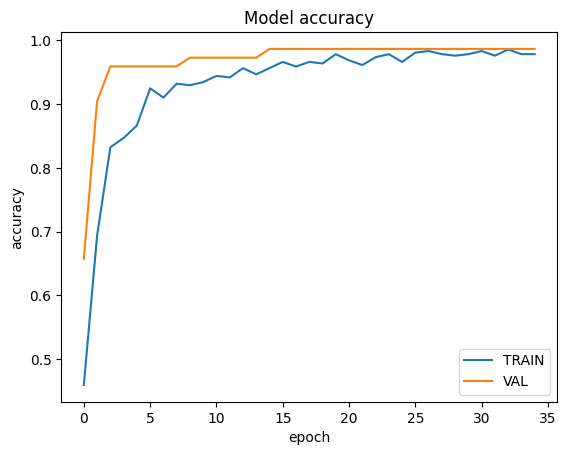

In [129]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

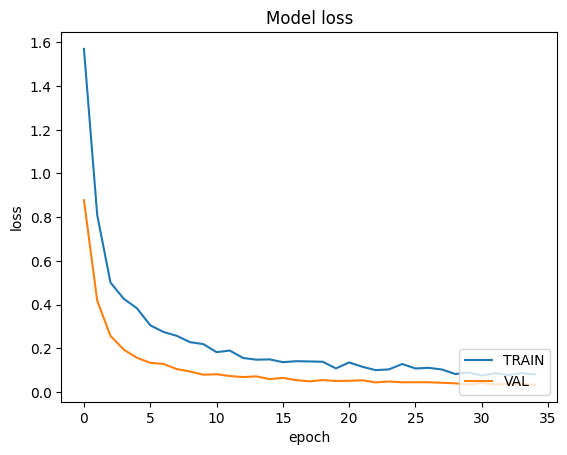

In [125]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [130]:
loss, accuracy = model.evaluate(X_test, y_test)

8/8 [==============================] - 0s 2ms/step - loss: 0.1040 - accuracy: 0.9748


8/8 [==============================] - 0s 2ms/step
Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

       chair       1.00      1.00      1.00        84
       cobra       0.75      1.00      0.86         9
         dog       0.91      1.00      0.95        29
        tree       1.00      1.00      1.00        93
     warrior       1.00      0.74      0.85        23

    accuracy                           0.97       238
   macro avg       0.93      0.95      0.93       238
weighted avg       0.98      0.97      0.97       238



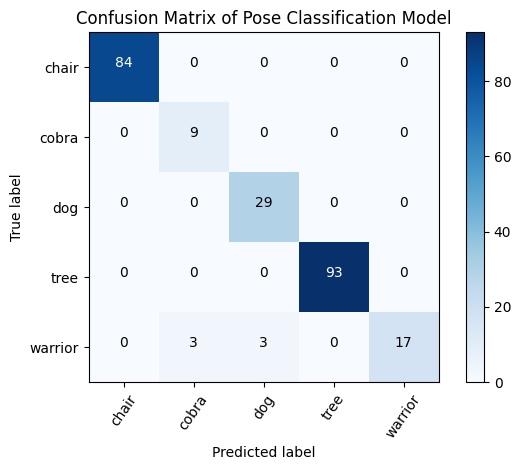

In [131]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

In [132]:
IMAGE_PER_ROW = 3
MAX_NO_OF_IMAGE_TO_PLOT = 30

# Extract the list of incorrectly predicted poses
false_predict = [id_in_df for id_in_df in range(len(y_test)) \
                if y_pred_label[id_in_df] != y_true_label[id_in_df]]
if len(false_predict) > MAX_NO_OF_IMAGE_TO_PLOT:
  false_predict = false_predict[:MAX_NO_OF_IMAGE_TO_PLOT]

# Plot the incorrectly predicted images
row_count = len(false_predict) // IMAGE_PER_ROW + 1
fig = plt.figure(figsize=(10 * IMAGE_PER_ROW, 10 * row_count))
for i, id_in_df in enumerate(false_predict):
  ax = fig.add_subplot(row_count, IMAGE_PER_ROW, i + 1)
  image_path = os.path.join(images_out_test_folder,
                            df_test.iloc[id_in_df]['file_name'])

  image = cv2.imread(image_path)
  plt.title("Predict: %s; Actual: %s"
            % (y_pred_label[id_in_df], y_true_label[id_in_df]))
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

Output hidden; open in https://colab.research.google.com to view.